# Eigenfaces

### import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
from time import perf_counter
from tqdm import notebook

from rputil import *

%matplotlib inline

### load data

In [2]:
n_images = 500

data = np.empty((62500, n_images), dtype='uint8') # images are 250x250

for i,filename in enumerate(glob.iglob('lfw/**/*.jpg', recursive = True)):
    if i >= n_images:
        break
    im=Image.open(filename)
    data[:,i] = np.asarray(im, dtype='uint8')[:,:,0].flatten() # only using red channel for now
    im.close()

#### column-center the data

In [3]:
data = data - np.expand_dims(np.mean(data, axis=1),1)

In [4]:
data.shape

(62500, 500)

### define factorization functions

In [5]:
def svd_rank_k(A, k):
    U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
    
    return U[:,:k], sigma[:k], Vh[:k]

In [6]:
# based on algorithms 4.1 (page 22) and 5.1 (page 29) of halko
# note that we are assuming Q has real entries in this implementation
def rsvd_rank_k(A, k, proj_dim=0.25):
    m, n = A.shape
    l = int(n * proj_dim)
    
    # Stage A
    omega = random.randn(n, l) # n x l
    Y = A @ omega # m x l
    Q, R = np.linalg.qr(Y) # m x l, l x l
    
    # Stage B
    B = Q.T @ A # l x n
    U_tilde, sigma, Vh = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde # m x r

    return U[:,:k], sigma[:k], Vh[:k]

### calculate eigenfaces

In [23]:
rows, cols = (3,5)
k = rows * cols

In [24]:
det_basis,det_sig,_ = svd_rank_k(data, k)
# print(det_basis.shape)

In [25]:
rand_basis,rand_sig,_ = rsvd_rank_k(data, k)
# print(rand_basis.shape)

In [26]:
# det_basis[:,0]

In [27]:
# rand_basis[:,0]

In [28]:
# det_sig

In [29]:
# rand_sig

In [31]:
def plot_eigenfaces(basis):
    fig, ax = plt.subplots(rows, cols, figsize=(15, 15 * rows / cols))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250), cmap='Greys')

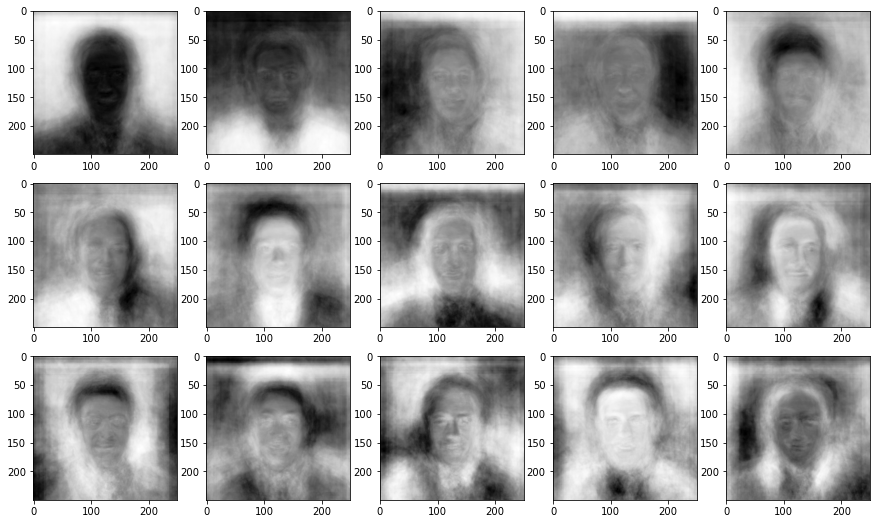

In [32]:
plot_eigenfaces(det_basis)

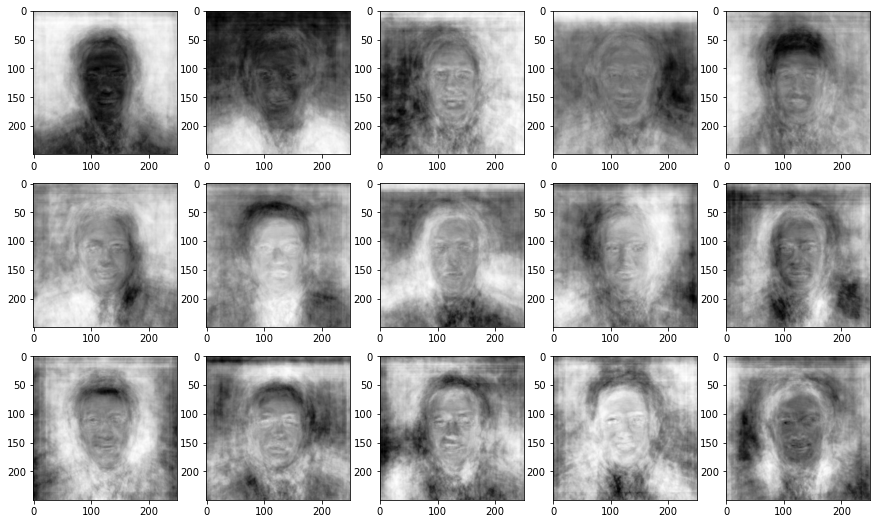

In [33]:
plot_eigenfaces(rand_basis)

### evaluate performance

In [52]:
proj_dim_range = np.arange(0.1, 0.9, 0.1)

start = perf_counter()
det_basis,_,_ = svd_rank_k(data, k)
end = perf_counter()
det_time = end - start

m, n = det_basis.shape


errors = []
rand_times = []

for d in proj_dim_range:
    print(f'Computing RSVD with subspace dimension {int(n * d)}...')
    
    start = perf_counter()
    rand_basis,_,_ = rsvd_rank_k(data, k, proj_dim=d)
    end = perf_counter()
    rand_time = end - start
    rand_times.append(rand_time)
    
    # possible sketchy fix for weird negative basis vectors
    for i in range(det_basis.shape[1]):
        if np.dot(det_basis[:,i], rand_basis[:,i]) < 0:
            rand_basis[:,i] *= -1
    
#     print(f'numer: {np.linalg.norm(rand_basis - det_basis)}, denom: {np.linalg.norm(det_basis)}')
    error = np.linalg.norm(rand_basis - det_basis) / np.linalg.norm(det_basis)
    errors.append(error)

Computing RSVD with subspace dimension 1...
Computing RSVD with subspace dimension 3...
Computing RSVD with subspace dimension 4...
Computing RSVD with subspace dimension 6...
Computing RSVD with subspace dimension 7...
Computing RSVD with subspace dimension 9...
Computing RSVD with subspace dimension 10...
Computing RSVD with subspace dimension 12...


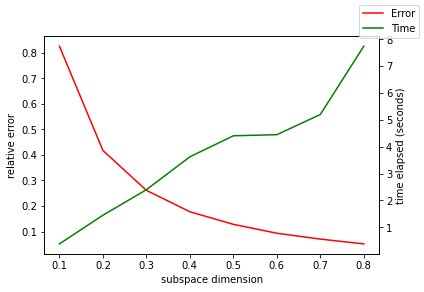

In [53]:
fig, ax = plt.subplots()

ax.set_xlabel('subspace dimension')

ax.plot(proj_dim_range, errors, c='r', label='Error')
ax.set_ylabel('relative error')

ax2 = ax.twinx()

ax2.plot(proj_dim_range, rand_times, c='g', label='Time')
ax2.set_ylabel('time elapsed (seconds)')

fig.legend(loc='upper right')

In [54]:
errors

[0.8246866247216105,
 0.4171534750674004,
 0.26122251519252637,
 0.1774956266619709,
 0.1282728191999303,
 0.09346059742907178,
 0.07057288177320277,
 0.05167239917357652]